## Overview
VegaFusion supports pre-transforming datasets within a Vega Spec and then generating a new spec with the transformed data included inline.

**Note**: This is fairly low-level functionality that is not yet integrated with Altair. It is designed to be a building block for larger Vega systems.

In [2]:
# imports
import json
from altair.vega import vega
import vegafusion as vf
import pandas as pd
import tzlocal

local_tz = tzlocal.get_localzone_name()

## Example 1: JSON url dataset
Consider a simple Vega-Lite histogram like the example at https://vega.github.io/vega-lite/examples/histogram.html

```json
{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {"url": "https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json"},
  "mark": "bar",
  "encoding": {
    "x": {
      "bin": true,
      "field": "IMDB Rating"
    },
    "y": {"aggregate": "count"}
  }
}

```

This compiles down into the following Vega specification:

In [3]:
full_spec = json.loads(r"""
{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "background": "white",
  "padding": 5,
  "width": 200,
  "height": 200,
  "style": "cell",
  "data": [
    {
      "name": "source_0",
      "url": "https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json",
      "format": {"type": "json"},
      "transform": [
        {
          "type": "extent",
          "field": "IMDB Rating",
          "signal": "bin_maxbins_10_IMDB_Rating_extent"
        },
        {
          "type": "bin",
          "field": "IMDB Rating",
          "as": [
            "bin_maxbins_10_IMDB Rating",
            "bin_maxbins_10_IMDB Rating_end"
          ],
          "signal": "bin_maxbins_10_IMDB_Rating_bins",
          "extent": {"signal": "bin_maxbins_10_IMDB_Rating_extent"},
          "maxbins": 10
        },
        {
          "type": "aggregate",
          "groupby": [
            "bin_maxbins_10_IMDB Rating",
            "bin_maxbins_10_IMDB Rating_end"
          ],
          "ops": ["count"],
          "fields": [null],
          "as": ["__count"]
        },
        {
          "type": "filter",
          "expr": "isValid(datum[\"bin_maxbins_10_IMDB Rating\"]) && isFinite(+datum[\"bin_maxbins_10_IMDB Rating\"])"
        }
      ]
    }
  ],
  "marks": [
    {
      "name": "marks",
      "type": "rect",
      "style": ["bar"],
      "from": {"data": "source_0"},
      "encode": {
        "update": {
          "fill": {"value": "#4c78a8"},
          "ariaRoleDescription": {"value": "bar"},
          "description": {
            "signal": "\"IMDB Rating (binned): \" + (!isValid(datum[\"bin_maxbins_10_IMDB Rating\"]) || !isFinite(+datum[\"bin_maxbins_10_IMDB Rating\"]) ? \"null\" : format(datum[\"bin_maxbins_10_IMDB Rating\"], \"\") + \" – \" + format(datum[\"bin_maxbins_10_IMDB Rating_end\"], \"\")) + \"; Count of Records: \" + (format(datum[\"__count\"], \"\"))"
          },
          "x2": {
            "scale": "x",
            "field": "bin_maxbins_10_IMDB Rating",
            "offset": 1
          },
          "x": {"scale": "x", "field": "bin_maxbins_10_IMDB Rating_end"},
          "y": {"scale": "y", "field": "__count"},
          "y2": {"scale": "y", "value": 0}
        }
      }
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "linear",
      "domain": {
        "signal": "[bin_maxbins_10_IMDB_Rating_bins.start, bin_maxbins_10_IMDB_Rating_bins.stop]"
      },
      "range": [0, {"signal": "width"}],
      "bins": {"signal": "bin_maxbins_10_IMDB_Rating_bins"},
      "zero": false
    },
    {
      "name": "y",
      "type": "linear",
      "domain": {"data": "source_0", "field": "__count"},
      "range": [{"signal": "height"}, 0],
      "nice": true,
      "zero": true
    }
  ],
  "axes": [
    {
      "scale": "y",
      "orient": "left",
      "gridScale": "x",
      "grid": true,
      "tickCount": {"signal": "ceil(height/40)"},
      "domain": false,
      "labels": false,
      "maxExtent": 0,
      "minExtent": 0,
      "ticks": false,
      "zindex": 0
    },
    {
      "scale": "x",
      "orient": "bottom",
      "grid": false,
      "title": "IMDB Rating (binned)",
      "labelFlush": true,
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(width/10)"},
      "zindex": 0
    },
    {
      "scale": "y",
      "orient": "left",
      "grid": false,
      "title": "Count of Records",
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(height/40)"},
      "zindex": 0
    }
  ]
}
""")

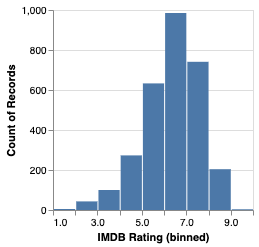

In [4]:
vega(full_spec)

VegaFusion provides a `pre_transform_spec` method that can be used to load the dataset and perform a variety of data transformations in the Python kernel process.

In [5]:
vf.runtime.pre_transform_spec?

Signature:
vf.runtime.pre_transform_spec(
    spec,
    local_tz,
    default_input_tz=None,
    row_limit=None,
    inline_datasets=None,
)
Docstring:
Evaluate supported transforms in an input Vega specification and produce a new
specification with pre-transformed datasets included inline.

:param spec: A Vega specification
:param local_tz: Name of timezone to be considered local. E.g. 'America/New_York'.
    This can be computed for the local system using the tzlocal package and the
    tzlocal.get_localzone_name() function.
:param default_input_tz: Name of timezone (e.g. 'America/New_York') that naive datetime
    strings should be interpreted in. Defaults to `local_tz`.
:param row_limit: Maximum number of dataset rows to include in the returned
    specification. If exceeded, datasets will be truncated to this number of rows
    and a RowLimitExceeded warning will be included in the resulting warnings list
:param inline_datasets: A dict from dataset names to pandas DataFrames or py

---

In this case, `pre_transform_spec` will load the specified `movies.json` file and then perform the `extent`, `bin`, and `aggregation` transforms.  The dataset that results from applying these transformations is included inline in the returned Vega specification

In [6]:
transformed_spec, warnings = vf.runtime.pre_transform_spec(full_spec, local_tz)

In [7]:
print(warnings)

[]


In [8]:
print(json.dumps(transformed_spec, indent=2))

{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "data": [
    {
      "name": "source_0",
      "values": [
        {
          "__count": 985,
          "bin_maxbins_10_IMDB Rating": 6.0,
          "bin_maxbins_10_IMDB Rating_end": 7.0
        },
        {
          "__count": 100,
          "bin_maxbins_10_IMDB Rating": 3.0,
          "bin_maxbins_10_IMDB Rating_end": 4.0
        },
        {
          "__count": 741,
          "bin_maxbins_10_IMDB Rating": 7.0,
          "bin_maxbins_10_IMDB Rating_end": 8.0
        },
        {
          "__count": 633,
          "bin_maxbins_10_IMDB Rating": 5.0,
          "bin_maxbins_10_IMDB Rating_end": 6.0
        },
        {
          "__count": 204,
          "bin_maxbins_10_IMDB Rating": 8.0,
          "bin_maxbins_10_IMDB Rating_end": 9.0
        },
        {
          "__count": 43,
          "bin_maxbins_10_IMDB Rating": 2.0,
          "bin_maxbins_10_IMDB Rating_end": 3.0
        },
        {
          "__count": 273,
  

---

When passed to the client for rendering by Vega, this transformed specification will produce the same chart as the original specification. In this case, however, the Vega JavaScript library does not need to load the dataset over the network or perform the `extent`, `bin`, and `aggregate` transforms.

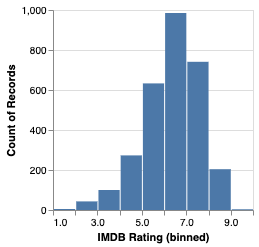

In [9]:
vega(transformed_spec)

## Example 2: DataFrame dataset
Suppose the `movies.json` dataset is already loaded into memory as a pandas `DataFrame`

In [10]:
movies = pd.read_json("https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json")
movies.head()

,Title,US Gross,Worldwide Gross,US DVD Sales,Production Budget,Release Date,MPAA Rating,Running Time min,Distributor,Source,Major Genre,Creative Type,Director,Rotten Tomatoes Rating,IMDB Rating,IMDB Votes
0,The Land Girls,146083.0,146083.0,NaN,8000000.0,Jun 12 1998,R,NaN,Gramercy,None,None,None,None,NaN,6.1,1071.0
1,"First Love, Last Rites",10876.0,10876.0,NaN,300000.0,Aug 07 1998,R,NaN,Strand,None,Drama,None,None,NaN,6.9,207.0
2,I Married a Strange Person,203134.0,203134.0,NaN,250000.0,Aug 28 1998,None,NaN,Lionsgate,None,Comedy,None,None,NaN,6.8,865.0
3,Let's Talk About Sex,373615.0,373615.0,NaN,300000.0,Sep 11 1998,None,NaN,Fine Line,None,Comedy,None,None,13.0,NaN,NaN
4,Slam,1009819.0,1087521.0,NaN,1000000.0,Oct 09 1998,R,NaN,Trimark,Original Screenplay,Drama,Contemporary Fiction,None,62.0,3.4,165.0


---

This DataFrame can be provided to `pre_transform_spec` method as a "named dataset", with name `"movies"`.  When a `DataFrame` is provided as a named dataset, it can be referenced by name from within the Vega specification using a special url syntax. In this case, the moveis dataset can be referenced as `"vegafusion+dataset://movies"`.  Here is the full specification:

In [11]:
full_spec_named = json.loads(r"""
{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "background": "white",
  "padding": 5,
  "width": 200,
  "height": 200,
  "style": "cell",
  "data": [
    {
      "name": "source_0",
      "url": "vegafusion+dataset://movies",
      "transform": [
        {
          "type": "extent",
          "field": "IMDB Rating",
          "signal": "bin_maxbins_10_IMDB_Rating_extent"
        },
        {
          "type": "bin",
          "field": "IMDB Rating",
          "as": [
            "bin_maxbins_10_IMDB Rating",
            "bin_maxbins_10_IMDB Rating_end"
          ],
          "signal": "bin_maxbins_10_IMDB_Rating_bins",
          "extent": {"signal": "bin_maxbins_10_IMDB_Rating_extent"},
          "maxbins": 10
        },
        {
          "type": "aggregate",
          "groupby": [
            "bin_maxbins_10_IMDB Rating",
            "bin_maxbins_10_IMDB Rating_end"
          ],
          "ops": ["count"],
          "fields": [null],
          "as": ["__count"]
        },
        {
          "type": "filter",
          "expr": "isValid(datum[\"bin_maxbins_10_IMDB Rating\"]) && isFinite(+datum[\"bin_maxbins_10_IMDB Rating\"])"
        }
      ]
    }
  ],
  "marks": [
    {
      "name": "marks",
      "type": "rect",
      "style": ["bar"],
      "from": {"data": "source_0"},
      "encode": {
        "update": {
          "fill": {"value": "#4c78a8"},
          "ariaRoleDescription": {"value": "bar"},
          "description": {
            "signal": "\"IMDB Rating (binned): \" + (!isValid(datum[\"bin_maxbins_10_IMDB Rating\"]) || !isFinite(+datum[\"bin_maxbins_10_IMDB Rating\"]) ? \"null\" : format(datum[\"bin_maxbins_10_IMDB Rating\"], \"\") + \" – \" + format(datum[\"bin_maxbins_10_IMDB Rating_end\"], \"\")) + \"; Count of Records: \" + (format(datum[\"__count\"], \"\"))"
          },
          "x2": {
            "scale": "x",
            "field": "bin_maxbins_10_IMDB Rating",
            "offset": 1
          },
          "x": {"scale": "x", "field": "bin_maxbins_10_IMDB Rating_end"},
          "y": {"scale": "y", "field": "__count"},
          "y2": {"scale": "y", "value": 0}
        }
      }
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "linear",
      "domain": {
        "signal": "[bin_maxbins_10_IMDB_Rating_bins.start, bin_maxbins_10_IMDB_Rating_bins.stop]"
      },
      "range": [0, {"signal": "width"}],
      "bins": {"signal": "bin_maxbins_10_IMDB_Rating_bins"},
      "zero": false
    },
    {
      "name": "y",
      "type": "linear",
      "domain": {"data": "source_0", "field": "__count"},
      "range": [{"signal": "height"}, 0],
      "nice": true,
      "zero": true
    }
  ],
  "axes": [
    {
      "scale": "y",
      "orient": "left",
      "gridScale": "x",
      "grid": true,
      "tickCount": {"signal": "ceil(height/40)"},
      "domain": false,
      "labels": false,
      "maxExtent": 0,
      "minExtent": 0,
      "ticks": false,
      "zindex": 0
    },
    {
      "scale": "x",
      "orient": "bottom",
      "grid": false,
      "title": "IMDB Rating (binned)",
      "labelFlush": true,
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(width/10)"},
      "zindex": 0
    },
    {
      "scale": "y",
      "orient": "left",
      "grid": false,
      "title": "Count of Records",
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(height/40)"},
      "zindex": 0
    }
  ]
}
""")

In [12]:
transformed_spec, warnings = vf.runtime.pre_transform_spec(
    full_spec_named, local_tz, inline_datasets=dict(movies=movies)
)

In [13]:
print(warnings)

[]


In [14]:
print(json.dumps(transformed_spec, indent=2))

{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "data": [
    {
      "name": "source_0",
      "values": [
        {
          "__count": 985,
          "bin_maxbins_10_IMDB Rating": 6.0,
          "bin_maxbins_10_IMDB Rating_end": 7.0
        },
        {
          "__count": 100,
          "bin_maxbins_10_IMDB Rating": 3.0,
          "bin_maxbins_10_IMDB Rating_end": 4.0
        },
        {
          "__count": 741,
          "bin_maxbins_10_IMDB Rating": 7.0,
          "bin_maxbins_10_IMDB Rating_end": 8.0
        },
        {
          "__count": 633,
          "bin_maxbins_10_IMDB Rating": 5.0,
          "bin_maxbins_10_IMDB Rating_end": 6.0
        },
        {
          "__count": 204,
          "bin_maxbins_10_IMDB Rating": 8.0,
          "bin_maxbins_10_IMDB Rating_end": 9.0
        },
        {
          "__count": 43,
          "bin_maxbins_10_IMDB Rating": 2.0,
          "bin_maxbins_10_IMDB Rating_end": 3.0
        },
        {
          "__count": 273,
  

---
Again, the resulting chart identical when rendered by Vega

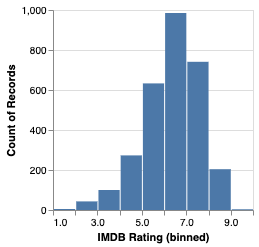

In [15]:
vega(transformed_spec)

## Example 3: RowLimit
And optional row limit can be provided to `pre_transform_spec` to set an upper bound on the number of rows that may be included inline in the resulting specification.  If this limit is exceeded, then the dataset will be truncated and a warning object will be returned.

Here is an artificial example of setting the row limit to 4 to demonstrate what happens.

In [16]:
transformed_spec, warnings = vf.runtime.pre_transform_spec(
    full_spec_named,
    local_tz,
    row_limit=4,
    inline_datasets=dict(movies=movies)
)

In [17]:
print(warnings)

[{'type': 'RowLimitExceeded', 'message': 'Some datasets in resulting Vega specification have been truncated to the provided row limit'}]


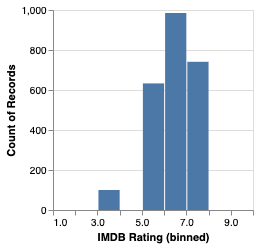

In [18]:
vega(transformed_spec)